# Predict Lg and Ld on test dataset

In [64]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from lib.models import *
import matplotlib.pyplot as plt
from scipy.io import savemat

plt.rcParams['font.family'] = 'Times New Roman'
idx_test = pickle.load(open('data/simulation_dataset/idx.pkl', 'rb'))['test']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Lg_simu = np.load('data/simulation_dataset/Lg_simu.npy')[idx_test][...,[1,3,4]]
Ld_simu = np.load('data/simulation_dataset/Ld.npy')[idx_test][...,[1,3,4]]
Ld_simu = Ld_simu[:,None,None,None,:] * np.ones_like(Lg_simu)
Lg_simu, Ld_simu = Lg_simu.reshape(-1, 3), Ld_simu.reshape(-1, 3)

In [ ]:
Lt_simu = np.load('data/simulation_dataset/Lt_simu.npy')[idx_test][...,[1,3,4]]
num_atm, num_vza, num_lst, num_emi, num_channel  = Lt_simu.shape

vzas = np.load('data/simulation_dataset/vzas.npy')[idx_test]
tpw = np.load('data/simulation_dataset/tpw.npy')[idx_test]
tpw_simu = tpw[:,None,None,None,None] * np.ones((num_atm, num_vza, num_lst, num_emi, 1))
vzas_simu = vzas[:,:,None,None,None] * np.ones((num_atm, num_vza, num_lst, num_emi, 1))
sec_vza = 1 / np.cos(np.deg2rad(vzas_simu))

# add random noise in Lt and tpw
# if you want to reproduce exactly the same results as the manuscript, please use the following code
np.random.seed(0)
noise_Lt = np.random.normal(0, 0.015, size=(67629, 6, 5, 5, 5))[idx_test][...,[1,3,4]] # np.random.normal(0, 0.015, size=Lt_simu.shape)
Lt_simu += noise_Lt
noise_tpw = np.random.normal(0, 0.04, size=(67629, 6, 5, 5, 1))[idx_test] # np.random.normal(0, 0.04, size=tpw_simu.shape)
tpw_simu *= (1+noise_tpw)

dL_45 = (Lt_simu[..., 1] - Lt_simu[..., 2])[..., None] # SW input
x = np.concatenate([Lt_simu[...,[0, 1]], dL_45, sec_vza, tpw_simu], axis=-1) # inputs

In [ ]:
# DL-SW model with tpw
num_input = x.shape[-1]
scaler = pickle.load(open('result/scaler/scaler_3b.pkl','rb'))
params_model = {'d_in': num_input, 'd_out': 3, 'd_block':128, 'd_hidden':64, 'n_block_l':3, 'n_block_h':2, 'act':'sigmoid', 'skip': True}
model = Res_MLP(**params_model).to(device)
weight_path = 'model/res_mlp/model_w_tpw.pt'
model.load_state_dict(torch.load(weight_path))

x_norm = scaler.transform(x.reshape(-1, num_input))
x_input = torch.tensor(x_norm, dtype=torch.float32).to(device)
results =  model(x_input)
Lg_dl, Ld_dl = results[0].detach().cpu().numpy(), results[1].detach().cpu().numpy()

rmse_Lg = root_mean_squared_error(Lg_simu, Lg_dl, multioutput='raw_values')
rmse_Ld = root_mean_squared_error(Ld_simu, Ld_dl, multioutput='raw_values')
print(f'rmse_Lg: {rmse_Lg}')
print(f'rmse_Ld: {rmse_Ld}')

# np.save('result/radiance/Lg_dl.npy', Lg_dl.astype(np.float32)) # Lg_dl_noisy
# np.save('result/radiance/Ld_dl.npy', Ld_dl.astype(np.float32)) # Ld_dl_noisy
# savemat('matlab_plot/data/rad_dl_w_tpw.mat', {'Lg_prd': Lg_dl.astype(np.float32), 'Ld_prd': Ld_dl.astype(np.float32), 'Lg_true': Lg_simu.astype(np.float32), 'Ld_true': Ld_simu.astype(np.float32)})

rmse_Lg: [0.08457022 0.08531072 0.10832808]
rmse_Ld: [0.25453338 0.30419976 0.33870837]


In [ ]:
# CatBoost model
from catboost import CatBoostRegressor, FeaturesData, Pool
model = CatBoostRegressor()
model.load_model("model/catboost/model_w_tpw_wo_noise.cbm")
# predict on test set
feature_data_test = FeaturesData(num_feature_data=x.reshape(-1, num_input).astype(np.float32))
pool_test = Pool(data=feature_data_test)
y_test_prd = model.predict(pool_test)
Lg_cat, Ld_cat = y_test_prd[:,:3], y_test_prd[:,3:]

rmse_Lg = root_mean_squared_error(Lg_simu, Lg_cat, multioutput='raw_values')
rmse_Ld = root_mean_squared_error(Ld_simu, Ld_cat, multioutput='raw_values')
print(f'rmse_Lg: {rmse_Lg}')
print(f'rmse_Ld: {rmse_Ld}')
# np.save('result/radiance/Lg_cat_noisy.npy', Lg_cat.astype(np.float32))
# np.save('result/radiance/Ld_cat_noisy.npy', Ld_cat.astype(np.float32))

rmse_Lg: [0.10729241 0.10129512 0.12336307]
rmse_Ld: [0.25958686 0.30954537 0.34479726]


In [ ]:
# DL-SW model without TPW
x = np.concatenate([Lt_simu[...,[0, 1]], dL_45, sec_vza], axis=-1)
num_input = x.shape[-1]
scaler = pickle.load(open('result/scaler/scaler_3b_wo_tpw.pkl','rb'))
params_model = {'d_in': num_input, 'd_out': 3, 'd_block':128, 'd_hidden':64, 'n_block_l':3, 'n_block_h':2, 'act':'sigmoid', 'skip': True}
model = Res_MLP(**params_model).to(device)
weight_path = 'model/res_mlp/model_wo_tpw.pt'
model.load_state_dict(torch.load(weight_path))

x_norm = scaler.transform(x.reshape(-1, num_input))
x_input = torch.tensor(x_norm, dtype=torch.float32).to(device)
results =  model(x_input)
Lg_dl, Ld_dl = results[0].detach().cpu().numpy(), results[1].detach().cpu().numpy()

rmse_Lg = root_mean_squared_error(Lg_simu, Lg_dl, multioutput='raw_values')
rmse_Ld = root_mean_squared_error(Ld_simu, Ld_dl, multioutput='raw_values')
print(f'rmse_Lg: {rmse_Lg}')
print(f'rmse_Ld: {rmse_Ld}')

# np.save('result/radiance/Lg_dl_wo_tpw.npy', Lg_dl.astype(np.float32)) # Lg_dl_wo_tpw_noisy
# np.save('result/radiance/Ld_dl_wo_tpw.npy', Ld_dl.astype(np.float32)) # Ld_dl_wo_tpw_noisy
# savemat('matlab_plot/data/rad_dl_wo_tpw.mat', {'Lg_prd': Lg_dl.astype(np.float32), 'Ld_prd': Ld_dl.astype(np.float32), 'Lg_true': Lg_simu.astype(np.float32), 'Ld_true': Ld_simu.astype(np.float32)})

rmse_Lg: [0.15119936 0.13630527 0.18116166]
rmse_Ld: [0.7589463 0.907247  1.0679315]


# comparison of final LST accuracy
## run TES from Lg and Ld

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from lib.tes import *
from lib.plot_custom import *
import glob
from sklearn.metrics import root_mean_squared_error

plt.rcParams['font.family'] = 'Times New Roman'

idx_test = pickle.load(open('data/simulation_dataset/idx.pkl', 'rb'))['test']
idx_clear = np.load('data/profile_info/idx_clear.npy')

my_tes_calculator = TES_calculator_vec(sensor='ecostress', n_bands=3)

# radiance withou uncertainties, for the test set
Lg_true = np.load('data/simulation_dataset/Lg_simu.npy')[idx_test][..., [1,3,4]]
Ld_true = np.load('data/simulation_dataset/Ld.npy')[idx_test][..., [1,3,4]]
Ld_true = Ld_true[:,None,None,None,:] * np.ones_like(Lg_true)
num_atm, num_vza, num_lst, num_emi, num_ch = Lg_true.shape

# true lst
lst_true = np.load('data/simulation_dataset/skt.npy')[idx_test]
lst_true = lst_true[:,None,:,None] * np.ones((num_atm, num_vza, num_lst, num_emi))
lst_true = lst_true.reshape(-1)

# true emi
emi_true = np.load('data/simulation_dataset/emi.npy')[idx_test][..., [1,3,4]]
emi_true = emi_true[:,None,...] * np.ones_like(Lg_true)
emi_true = emi_true.reshape(-1, 3)

# tes lst without errors
dic = pickle.load(open('result/tes/tes_wo_error.pkl', 'rb'))
lst_tes, qa_tes = dic['lst'], dic['qa']

In [70]:
def run_TES(Lg_input, Ld_input, save_path = None):
    Lg_ = np.swapaxes(Lg_input, 0, 1)[:,:,None]
    Ld_ = np.swapaxes(Ld_input, 0, 1)[:,:,None]

    lst_prd, emi_prd, qa_prd, _ = my_tes_calculator(Lg_, Ld_)
    lst_prd, emi_prd, qa_prd = lst_prd.squeeze(), emi_prd.squeeze(), qa_prd.squeeze()
    emi_prd = np.swapaxes(emi_prd, 0, 1)

    if save_path is not None:
        pickle.dump({'lst': lst_prd.astype(np.float32), 
                     'emi': emi_prd.astype(np.float32), 
                     'qa': qa_prd.astype(np.int8)}, 
                     open(save_path, 'wb'))

    return lst_prd, emi_prd, qa_prd

In [74]:
# run TES and save the results
Lg_dl = np.load('result/radiance/Lg_dl_noisy.npy')
Ld_dl = np.load('result/radiance/Ld_dl_noisy.npy')

# change Lg and Ld source
Lg_input, Ld_input = Lg_dl, Ld_dl
save_path = None # 'result/tes/dl_wo_tpw_w_error.pkl'
lst_prd, _, qa_prd = run_TES(Lg_input, Ld_input, save_path)

TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014437
NEM Iteration: 2
Undecided pixels: 1014437
NEM Iteration: 3
Undecided pixels: 1014437
NEM Iteration: 4
Undecided pixels: 185132
NEM Iteration: 5
Undecided pixels: 72818
NEM Iteration: 6
Undecided pixels: 25591
NEM Iteration: 7
Undecided pixels: 8927
NEM Iteration: 8
Undecided pixels: 3270
NEM Iteration: 9
Undecided pixels: 1293
NEM Iteration: 10
Undecided pixels: 536
NEM Iteration: 11
Undecided pixels: 248
NEM Iteration: 12
Undecided pixels: 113
NEM Iteration: 13
Undecided pixels: 54
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 249513
NEM Iteration: 2
Undecided pixels: 249513
NEM Iteration: 3
Undecided pixels: 249513
NEM Iteration: 4
Undecided pixels: 99078
NEM Iteration: 5
Undecided pixels: 43022
NEM Iteration: 6
Undecided pixels: 15072
NEM Iteration: 7
Undecided pixels: 5044
NEM Iteration: 8
Undecided pixels: 1688
NEM Iteration: 9
Undecided pixels: 603
NEM Iteration: 10
Undecided pix

In [ ]:
# DL-SW-TES with tpw
dic_dl_1 = pickle.load(open('result/tes/dl_w_tpw_wo_error.pkl', 'rb'))
dic_dl_2 = pickle.load(open('result/tes/dl_w_tpw_w_error.pkl', 'rb'))
lst_dl, qa_dl = dic_dl_1['lst'], dic_dl_1['qa']
lst_dl_noisy, qa_dl_noisy = dic_dl_2['lst'], dic_dl_2['qa']
lst_true = np.load('result/tes/lst_true.npy')

savemat('matlab_plot/data/lst_dl_w_tpw.mat', {'lst_true': lst_true.astype(np.float32), 'lst_dl': lst_dl.astype(np.float32), 'qa_dl': qa_dl.astype(np.int8),
                                                'lst_dl_noisy': lst_dl_noisy.astype(np.float32), 'qa_dl_noisy': qa_dl_noisy.astype(np.int8)})

# DL-SW-TES without tpw
dic = pickle.load(open('result/tes/dl_wo_tpw_w_error.pkl', 'rb'))
lst_dl, qa_dl = dic['lst'], dic['qa']
lst_true = np.load('result/tes/lst_true.npy')
savemat('matlab_plot/data/lst_dl_wo_tpw.mat', {'lst_true': lst_true[qa_dl==1].astype(np.float32), 'lst_prd': lst_dl[qa_dl==1].astype(np.float32)})

## Accuracy of TES and DL-SW-TES with input errors

In [ ]:
# TES with measurement noise and shift errors in profiles (we do not save the TES results)
Lt_true = np.load('data/simulation_dataset/Lt_simu.npy')[idx_test][..., [1,3,4]]
# add NEdT to Lt
np.random.seed(0)
std_Lt = 0.015
noise_Lt = np.random.normal(0, std_Lt, size=Lt_true.shape)
Lt_noise = Lt_true + noise_Lt

strs = ['n20', 'n15', 'n10', 'n05', 'true', 'p05', 'p10', 'p15', 'p20']
rmse_tes, ratio_tes = [], []

for stri in tqdm(strs):
    atm_params = pickle.load(open(f'data/atm_params/atm_params_{stri}.pkl', 'rb'))
    if stri == 'true':
        atm_params['Lu'] = atm_params['Lu'][idx_clear]
        atm_params['Ld'] = atm_params['Ld'][idx_clear]
        atm_params['tau'] = atm_params['tau'][idx_clear]
        
    Lu_, Ld_, tau_ = atm_params['Lu'][idx_test][..., [1,3,4]], atm_params['Ld'][idx_test][..., [1,3,4]], atm_params['tau'][idx_test][..., [1,3,4]]
    Lg_ = (Lt_noise - Lu_[:,:,None,None,:]) / tau_[:,:,None,None,:]
    Ld_ = Ld_[:,None,None,None,:] * np.ones_like(Lg_)

    lst_prd, _, qa_prd = run_TES(Lg_, Ld_)

    qa_com = qa_tes * qa_prd
    rmsei = root_mean_squared_error(lst_tes[qa_com==1], lst_prd[qa_com==1])
    rmse_tes.append(rmsei)

    ratioi = np.sum(qa_prd==1) / len(qa_prd)
    ratio_tes.append(ratioi)

# np.save('result/accuracy_metric/rmse_tes_shift_error.npy', rmse_tes)

  0%|          | 0/9 [00:00<?, ?it/s]

TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014450
NEM Iteration: 2
Undecided pixels: 1014450
NEM Iteration: 3
Undecided pixels: 1014450
NEM Iteration: 4
Undecided pixels: 303821
NEM Iteration: 5
Undecided pixels: 204074
NEM Iteration: 6
Undecided pixels: 143248
NEM Iteration: 7
Undecided pixels: 103864
NEM Iteration: 8
Undecided pixels: 75565
NEM Iteration: 9
Undecided pixels: 56319
NEM Iteration: 10
Undecided pixels: 40656
NEM Iteration: 11
Undecided pixels: 28820
NEM Iteration: 12
Undecided pixels: 20385
NEM Iteration: 13
Undecided pixels: 14666
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 434834
NEM Iteration: 2
Undecided pixels: 434834
NEM Iteration: 3
Undecided pixels: 434834
NEM Iteration: 4
Undecided pixels: 250170
NEM Iteration: 5
Undecided pixels: 177203
NEM Iteration: 6
Undecided pixels: 127143
NEM Iteration: 7
Undecided pixels: 90927
NEM Iteration: 8
Undecided pixels: 63797
NEM Iteration: 9
Undecided pixels: 44810
NEM Itera

 11%|█         | 1/9 [00:07<01:00,  7.62s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014450
NEM Iteration: 2
Undecided pixels: 1014450
NEM Iteration: 3
Undecided pixels: 1014450
NEM Iteration: 4
Undecided pixels: 306303
NEM Iteration: 5
Undecided pixels: 206841
NEM Iteration: 6
Undecided pixels: 146641
NEM Iteration: 7
Undecided pixels: 108676
NEM Iteration: 8
Undecided pixels: 80973
NEM Iteration: 9
Undecided pixels: 62205
NEM Iteration: 10
Undecided pixels: 47183
NEM Iteration: 11
Undecided pixels: 35020
NEM Iteration: 12
Undecided pixels: 25921
NEM Iteration: 13
Undecided pixels: 19365
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 410731
NEM Iteration: 2
Undecided pixels: 410731
NEM Iteration: 3
Undecided pixels: 410731
NEM Iteration: 4
Undecided pixels: 235390
NEM Iteration: 5
Undecided pixels: 169686
NEM Iteration: 6
Undecided pixels: 123359
NEM Iteration: 7
Undecided pixels: 90820
NEM Iteration: 8
Undecided pixels: 65168
NEM Iteration:

 22%|██▏       | 2/9 [00:14<00:52,  7.48s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014450
NEM Iteration: 2
Undecided pixels: 1014450
NEM Iteration: 3
Undecided pixels: 1014450
NEM Iteration: 4
Undecided pixels: 301965
NEM Iteration: 5
Undecided pixels: 200102
NEM Iteration: 6
Undecided pixels: 140846
NEM Iteration: 7
Undecided pixels: 104300
NEM Iteration: 8
Undecided pixels: 79086
NEM Iteration: 9
Undecided pixels: 61501
NEM Iteration: 10
Undecided pixels: 47704
NEM Iteration: 11
Undecided pixels: 36343
NEM Iteration: 12
Undecided pixels: 27639
NEM Iteration: 13
Undecided pixels: 21448
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 377548
NEM Iteration: 2
Undecided pixels: 377548
NEM Iteration: 3
Undecided pixels: 377548
NEM Iteration: 4
Undecided pixels: 208881
NEM Iteration: 5
Undecided pixels: 150896
NEM Iteration: 6
Undecided pixels: 111093
NEM Iteration: 7
Undecided pixels: 82935
NEM Iteration: 8
Undecided pixels: 61325
NEM Iteration:

 33%|███▎      | 3/9 [00:22<00:43,  7.32s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014450
NEM Iteration: 2
Undecided pixels: 1014450
NEM Iteration: 3
Undecided pixels: 1014450
NEM Iteration: 4
Undecided pixels: 282594
NEM Iteration: 5
Undecided pixels: 175141
NEM Iteration: 6
Undecided pixels: 115912
NEM Iteration: 7
Undecided pixels: 82976
NEM Iteration: 8
Undecided pixels: 62091
NEM Iteration: 9
Undecided pixels: 47185
NEM Iteration: 10
Undecided pixels: 35713
NEM Iteration: 11
Undecided pixels: 27165
NEM Iteration: 12
Undecided pixels: 20961
NEM Iteration: 13
Undecided pixels: 16364
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 326937
NEM Iteration: 2
Undecided pixels: 326937
NEM Iteration: 3
Undecided pixels: 326937
NEM Iteration: 4
Undecided pixels: 162072
NEM Iteration: 5
Undecided pixels: 108155
NEM Iteration: 6
Undecided pixels: 78235
NEM Iteration: 7
Undecided pixels: 59741
NEM Iteration: 8
Undecided pixels: 45639
NEM Iteration: 9

 44%|████▍     | 4/9 [00:28<00:35,  7.07s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014450
NEM Iteration: 2
Undecided pixels: 1014450
NEM Iteration: 3
Undecided pixels: 1014450
NEM Iteration: 4
Undecided pixels: 240340
NEM Iteration: 5
Undecided pixels: 120296
NEM Iteration: 6
Undecided pixels: 60012
NEM Iteration: 7
Undecided pixels: 32547
NEM Iteration: 8
Undecided pixels: 19239
NEM Iteration: 9
Undecided pixels: 12423
NEM Iteration: 10
Undecided pixels: 8413
NEM Iteration: 11
Undecided pixels: 6032
NEM Iteration: 12
Undecided pixels: 4522
NEM Iteration: 13
Undecided pixels: 3449
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 286661
NEM Iteration: 2
Undecided pixels: 286661
NEM Iteration: 3
Undecided pixels: 286661
NEM Iteration: 4
Undecided pixels: 124297
NEM Iteration: 5
Undecided pixels: 64147
NEM Iteration: 6
Undecided pixels: 31132
NEM Iteration: 7
Undecided pixels: 16604
NEM Iteration: 8
Undecided pixels: 10048
NEM Iteration: 9
Undec

 56%|█████▌    | 5/9 [00:35<00:27,  6.80s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014450
NEM Iteration: 2
Undecided pixels: 1014450
NEM Iteration: 3
Undecided pixels: 1014450
NEM Iteration: 4
Undecided pixels: 306542
NEM Iteration: 5
Undecided pixels: 179557
NEM Iteration: 6
Undecided pixels: 103016
NEM Iteration: 7
Undecided pixels: 59435
NEM Iteration: 8
Undecided pixels: 34254
NEM Iteration: 9
Undecided pixels: 19870
NEM Iteration: 10
Undecided pixels: 11526
NEM Iteration: 11
Undecided pixels: 6557
NEM Iteration: 12
Undecided pixels: 3693
NEM Iteration: 13
Undecided pixels: 1987
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 403879
NEM Iteration: 2
Undecided pixels: 403879
NEM Iteration: 3
Undecided pixels: 403879
NEM Iteration: 4
Undecided pixels: 238160
NEM Iteration: 5
Undecided pixels: 146524
NEM Iteration: 6
Undecided pixels: 82382
NEM Iteration: 7
Undecided pixels: 45819
NEM Iteration: 8
Undecided pixels: 25201
NEM Iteration: 9
Un

 67%|██████▋   | 6/9 [00:42<00:20,  6.84s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014450
NEM Iteration: 2
Undecided pixels: 1014450
NEM Iteration: 3
Undecided pixels: 1014450
NEM Iteration: 4
Undecided pixels: 358182
NEM Iteration: 5
Undecided pixels: 232907
NEM Iteration: 6
Undecided pixels: 149177
NEM Iteration: 7
Undecided pixels: 96177
NEM Iteration: 8
Undecided pixels: 62028
NEM Iteration: 9
Undecided pixels: 39583
NEM Iteration: 10
Undecided pixels: 25403
NEM Iteration: 11
Undecided pixels: 16076
NEM Iteration: 12
Undecided pixels: 10179
NEM Iteration: 13
Undecided pixels: 6188
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 486548
NEM Iteration: 2
Undecided pixels: 486548
NEM Iteration: 3
Undecided pixels: 486548
NEM Iteration: 4
Undecided pixels: 311828
NEM Iteration: 5
Undecided pixels: 204481
NEM Iteration: 6
Undecided pixels: 128739
NEM Iteration: 7
Undecided pixels: 80930
NEM Iteration: 8
Undecided pixels: 50402
NEM Iteration: 9

 78%|███████▊  | 7/9 [00:49<00:14,  7.04s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014450
NEM Iteration: 2
Undecided pixels: 1014450
NEM Iteration: 3
Undecided pixels: 1014448
NEM Iteration: 4
Undecided pixels: 395549
NEM Iteration: 5
Undecided pixels: 276099
NEM Iteration: 6
Undecided pixels: 186495
NEM Iteration: 7
Undecided pixels: 126317
NEM Iteration: 8
Undecided pixels: 85187
NEM Iteration: 9
Undecided pixels: 57098
NEM Iteration: 10
Undecided pixels: 38671
NEM Iteration: 11
Undecided pixels: 25684
NEM Iteration: 12
Undecided pixels: 16563
NEM Iteration: 13
Undecided pixels: 10633
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 535162
NEM Iteration: 2
Undecided pixels: 535162
NEM Iteration: 3
Undecided pixels: 535162
NEM Iteration: 4
Undecided pixels: 355229
NEM Iteration: 5
Undecided pixels: 247058
NEM Iteration: 6
Undecided pixels: 163766
NEM Iteration: 7
Undecided pixels: 108178
NEM Iteration: 8
Undecided pixels: 70131
NEM Iteration

 89%|████████▉ | 8/9 [00:57<00:07,  7.29s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014450
NEM Iteration: 2
Undecided pixels: 1014450
NEM Iteration: 3
Undecided pixels: 1014258
NEM Iteration: 4
Undecided pixels: 423695
NEM Iteration: 5
Undecided pixels: 309639
NEM Iteration: 6
Undecided pixels: 219223
NEM Iteration: 7
Undecided pixels: 151256
NEM Iteration: 8
Undecided pixels: 103773
NEM Iteration: 9
Undecided pixels: 71058
NEM Iteration: 10
Undecided pixels: 49169
NEM Iteration: 11
Undecided pixels: 33509
NEM Iteration: 12
Undecided pixels: 21986
NEM Iteration: 13
Undecided pixels: 14347
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 569661
NEM Iteration: 2
Undecided pixels: 569661
NEM Iteration: 3
Undecided pixels: 569661
NEM Iteration: 4
Undecided pixels: 385458
NEM Iteration: 5
Undecided pixels: 280347
NEM Iteration: 6
Undecided pixels: 193641
NEM Iteration: 7
Undecided pixels: 130051
NEM Iteration: 8
Undecided pixels: 85807
NEM Iteratio

100%|██████████| 9/9 [01:05<00:00,  7.26s/it]

MMD module completed
TES completed!


In [ ]:
import torch
from lib.models import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = pickle.load(open('result/scaler/scaler_3b.pkl','rb'))

params_model = {'d_in': 5, 'd_out': 3, 'd_block':128, 'd_hidden':64, 'n_block_l':3, 'n_block_h':2, 'act':'sigmoid', 'skip': True}
model = Res_MLP(**params_model).to(device)
weight_path = 'model/res_mlp/model_w_tpw.pt'
model.load_state_dict(torch.load(weight_path))

vzas = np.load('data/simulation_dataset/vzas.npy')[idx_test]
vzas = vzas[:,:,None,None] * np.ones((num_atm, num_vza, num_lst, num_emi))
sec_vza = 1 / np.cos(np.deg2rad(vzas))
sec_vza = sec_vza.reshape(-1)
tpw = np.load('data/simulation_dataset/tpw.npy')[idx_test]

Lt_noise_ = Lt_noise.reshape(-1, num_ch)

In [25]:
ratio_tpw = np.arange(0.8, 1.21, 0.05)
rmse_dl, ratio_dl = [], []

for ratio in tqdm(ratio_tpw):
    tpw_ = tpw * ratio
    tpw_ = tpw_[:,None,None,None] * np.ones((num_atm, num_vza, num_lst, num_emi))
    tpw_ = tpw_.reshape(-1)

    X = np.array([Lt_noise_[:,0], Lt_noise_[:,1], Lt_noise_[:,1]-Lt_noise_[:,2], sec_vza, tpw_]).T
    X = scaler.transform(X)
    X = torch.tensor(X, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        results = model(X)
    Lg_dl, Ld_dl = results[0].cpu().numpy(), results[1].cpu().numpy()

    Lg_dl = np.swapaxes(Lg_dl, 0, 1)[:,:,None]
    Ld_dl = np.swapaxes(Ld_dl, 0, 1)[:,:,None]

    lst_prd, _, qa_prd, _ = my_tes_calculator(Lg_dl, Ld_dl)
    lst_prd, qa_prd = lst_prd.squeeze(), qa_prd.squeeze()

    qa_com = qa_tes * qa_prd
    rmsei = root_mean_squared_error(lst_tes[qa_com==1], lst_prd[qa_com==1])
    rmse_dl.append(rmsei)

    ratioi = np.sum(qa_prd==1) / len(qa_prd)
    ratio_tes.append(ratioi)

# np.save('result/accuracy_metric/rmse_dl_shift_error.npy', rmse_dl)

  0%|          | 0/9 [00:00<?, ?it/s]

TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014433
NEM Iteration: 2
Undecided pixels: 1014433
NEM Iteration: 3
Undecided pixels: 1014433
NEM Iteration: 4
Undecided pixels: 106785
NEM Iteration: 5
Undecided pixels: 25209
NEM Iteration: 6
Undecided pixels: 5272
NEM Iteration: 7
Undecided pixels: 1046
NEM Iteration: 8
Undecided pixels: 150
NEM Iteration: 9
Undecided pixels: 20
NEM Iteration: 10
Undecided pixels: 5
NEM module completed
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 240164
NEM Iteration: 2
Undecided pixels: 240164
NEM Iteration: 3
Undecided pixels: 240164
NEM Iteration: 4
Undecided pixels: 67105
NEM Iteration: 5
Undecided pixels: 17953
NEM Iteration: 6
Undecided pixels: 4477
NEM Iteration: 7
Undecided pixels: 947
NEM Iteration: 8
Undecided pixels: 123
NEM Iteration: 9
Undecided pixels: 21
NEM Iteration: 10
Undecided pixels: 5
NEM module completed
All pixels completed
RATIO module completed


 11%|█         | 1/9 [00:08<01:10,  8.83s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014435
NEM Iteration: 2
Undecided pixels: 1014435
NEM Iteration: 3
Undecided pixels: 1014435
NEM Iteration: 4
Undecided pixels: 116918
NEM Iteration: 5
Undecided pixels: 30096
NEM Iteration: 6
Undecided pixels: 6403
NEM Iteration: 7
Undecided pixels: 1208
NEM Iteration: 8
Undecided pixels: 195
NEM Iteration: 9
Undecided pixels: 17
NEM Iteration: 10
Undecided pixels: 5
NEM module completed
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 237312
NEM Iteration: 2
Undecided pixels: 237312
NEM Iteration: 3
Undecided pixels: 237312
NEM Iteration: 4
Undecided pixels: 71167
NEM Iteration: 5
Undecided pixels: 20864
NEM Iteration: 6
Undecided pixels: 4920
NEM Iteration: 7
Undecided pixels: 1011
NEM Iteration: 8
Undecided pixels: 156
NEM Iteration: 9
Undecided pixels: 11
NEM Iteration: 10
Undecided pixels: 5
NEM module completed
All pixels completed
RATIO module completed

 22%|██▏       | 2/9 [00:13<00:43,  6.26s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014435
NEM Iteration: 2
Undecided pixels: 1014435
NEM Iteration: 3
Undecided pixels: 1014435
NEM Iteration: 4
Undecided pixels: 134761
NEM Iteration: 5
Undecided pixels: 40040
NEM Iteration: 6
Undecided pixels: 9569
NEM Iteration: 7
Undecided pixels: 2030
NEM Iteration: 8
Undecided pixels: 359
NEM Iteration: 9
Undecided pixels: 69
NEM Iteration: 10
Undecided pixels: 6
NEM module completed
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 238393
NEM Iteration: 2
Undecided pixels: 238393
NEM Iteration: 3
Undecided pixels: 238393
NEM Iteration: 4
Undecided pixels: 78066
NEM Iteration: 5
Undecided pixels: 25955
NEM Iteration: 6
Undecided pixels: 6492
NEM Iteration: 7
Undecided pixels: 1398
NEM Iteration: 8
Undecided pixels: 237
NEM Iteration: 9
Undecided pixels: 53
NEM Iteration: 10
Undecided pixels: 5
NEM module completed
All pixels completed
RATIO module completed

 33%|███▎      | 3/9 [00:17<00:32,  5.42s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014435
NEM Iteration: 2
Undecided pixels: 1014435
NEM Iteration: 3
Undecided pixels: 1014435
NEM Iteration: 4
Undecided pixels: 158431
NEM Iteration: 5
Undecided pixels: 54273
NEM Iteration: 6
Undecided pixels: 15523
NEM Iteration: 7
Undecided pixels: 4244
NEM Iteration: 8
Undecided pixels: 1042
NEM Iteration: 9
Undecided pixels: 272
NEM Iteration: 10
Undecided pixels: 76
NEM Iteration: 11
Undecided pixels: 22
NEM Iteration: 12
Undecided pixels: 3
NEM module completed
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 242479
NEM Iteration: 2
Undecided pixels: 242479
NEM Iteration: 3
Undecided pixels: 242479
NEM Iteration: 4
Undecided pixels: 87514
NEM Iteration: 5
Undecided pixels: 33372
NEM Iteration: 6
Undecided pixels: 9468
NEM Iteration: 7
Undecided pixels: 2547
NEM Iteration: 8
Undecided pixels: 669
NEM Iteration: 9
Undecided pixels: 168
NEM Iteration: 10
Un

 44%|████▍     | 4/9 [00:22<00:26,  5.26s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014436
NEM Iteration: 2
Undecided pixels: 1014436
NEM Iteration: 3
Undecided pixels: 1014436
NEM Iteration: 4
Undecided pixels: 184656
NEM Iteration: 5
Undecided pixels: 71501
NEM Iteration: 6
Undecided pixels: 24559
NEM Iteration: 7
Undecided pixels: 8316
NEM Iteration: 8
Undecided pixels: 2813
NEM Iteration: 9
Undecided pixels: 944
NEM Iteration: 10
Undecided pixels: 324
NEM Iteration: 11
Undecided pixels: 147
NEM Iteration: 12
Undecided pixels: 47
NEM Iteration: 13
Undecided pixels: 18
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 248878
NEM Iteration: 2
Undecided pixels: 248878
NEM Iteration: 3
Undecided pixels: 248878
NEM Iteration: 4
Undecided pixels: 98863
NEM Iteration: 5
Undecided pixels: 42576
NEM Iteration: 6
Undecided pixels: 14407
NEM Iteration: 7
Undecided pixels: 4694
NEM Iteration: 8
Undecided pixels: 1454
NEM Iteration: 9
Undecided pixels: 4

 56%|█████▌    | 5/9 [00:28<00:21,  5.34s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014437
NEM Iteration: 2
Undecided pixels: 1014437
NEM Iteration: 3
Undecided pixels: 1014437
NEM Iteration: 4
Undecided pixels: 213250
NEM Iteration: 5
Undecided pixels: 92256
NEM Iteration: 6
Undecided pixels: 36907
NEM Iteration: 7
Undecided pixels: 14455
NEM Iteration: 8
Undecided pixels: 6068
NEM Iteration: 9
Undecided pixels: 2616
NEM Iteration: 10
Undecided pixels: 1198
NEM Iteration: 11
Undecided pixels: 548
NEM Iteration: 12
Undecided pixels: 243
NEM Iteration: 13
Undecided pixels: 125
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 257005
NEM Iteration: 2
Undecided pixels: 257005
NEM Iteration: 3
Undecided pixels: 257005
NEM Iteration: 4
Undecided pixels: 111374
NEM Iteration: 5
Undecided pixels: 53334
NEM Iteration: 6
Undecided pixels: 20964
NEM Iteration: 7
Undecided pixels: 7835
NEM Iteration: 8
Undecided pixels: 3031
NEM Iteration: 9
Undecided pix

 67%|██████▋   | 6/9 [00:33<00:15,  5.28s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014438
NEM Iteration: 2
Undecided pixels: 1014438
NEM Iteration: 3
Undecided pixels: 1014438
NEM Iteration: 4
Undecided pixels: 244205
NEM Iteration: 5
Undecided pixels: 115926
NEM Iteration: 6
Undecided pixels: 52700
NEM Iteration: 7
Undecided pixels: 23981
NEM Iteration: 8
Undecided pixels: 11475
NEM Iteration: 9
Undecided pixels: 5922
NEM Iteration: 10
Undecided pixels: 3258
NEM Iteration: 11
Undecided pixels: 1878
NEM Iteration: 12
Undecided pixels: 1119
NEM Iteration: 13
Undecided pixels: 685
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 267341
NEM Iteration: 2
Undecided pixels: 267341
NEM Iteration: 3
Undecided pixels: 267341
NEM Iteration: 4
Undecided pixels: 125750
NEM Iteration: 5
Undecided pixels: 65952
NEM Iteration: 6
Undecided pixels: 29813
NEM Iteration: 7
Undecided pixels: 12853
NEM Iteration: 8
Undecided pixels: 5639
NEM Iteration: 9
Undecide

 78%|███████▊  | 7/9 [00:38<00:10,  5.33s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014439
NEM Iteration: 2
Undecided pixels: 1014439
NEM Iteration: 3
Undecided pixels: 1014439
NEM Iteration: 4
Undecided pixels: 275296
NEM Iteration: 5
Undecided pixels: 143192
NEM Iteration: 6
Undecided pixels: 72848
NEM Iteration: 7
Undecided pixels: 37257
NEM Iteration: 8
Undecided pixels: 20144
NEM Iteration: 9
Undecided pixels: 11623
NEM Iteration: 10
Undecided pixels: 7095
NEM Iteration: 11
Undecided pixels: 4681
NEM Iteration: 12
Undecided pixels: 3216
NEM Iteration: 13
Undecided pixels: 2264
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 280382
NEM Iteration: 2
Undecided pixels: 280382
NEM Iteration: 3
Undecided pixels: 280382
NEM Iteration: 4
Undecided pixels: 142294
NEM Iteration: 5
Undecided pixels: 80716
NEM Iteration: 6
Undecided pixels: 40723
NEM Iteration: 7
Undecided pixels: 19310
NEM Iteration: 8
Undecided pixels: 9396
NEM Iteration: 9
Undeci

 89%|████████▉ | 8/9 [00:44<00:05,  5.37s/it]

MMD module completed
TES completed!
TES starting...
NEM starting...
NEM Iteration: 1
Undecided pixels: 1014439
NEM Iteration: 2
Undecided pixels: 1014439
NEM Iteration: 3
Undecided pixels: 1014439
NEM Iteration: 4
Undecided pixels: 305892
NEM Iteration: 5
Undecided pixels: 170950
NEM Iteration: 6
Undecided pixels: 95804
NEM Iteration: 7
Undecided pixels: 54710
NEM Iteration: 8
Undecided pixels: 32116
NEM Iteration: 9
Undecided pixels: 20269
NEM Iteration: 10
Undecided pixels: 13517
NEM Iteration: 11
Undecided pixels: 9416
NEM Iteration: 12
Undecided pixels: 6907
NEM Iteration: 13
Undecided pixels: 5100
All pixels completed
NEM starting...
NEM Iteration: 1
Undecided pixels: 296861
NEM Iteration: 2
Undecided pixels: 296861
NEM Iteration: 3
Undecided pixels: 296861
NEM Iteration: 4
Undecided pixels: 161436
NEM Iteration: 5
Undecided pixels: 98450
NEM Iteration: 6
Undecided pixels: 54449
NEM Iteration: 7
Undecided pixels: 28791
NEM Iteration: 8
Undecided pixels: 15011
NEM Iteration: 9
Unde

100%|██████████| 9/9 [00:49<00:00,  5.54s/it]

MMD module completed
TES completed!


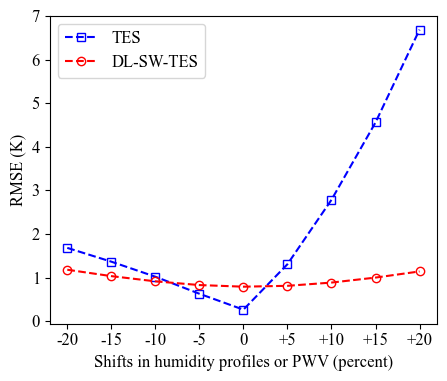

In [ ]:
plt.rcParams['font.size'] = 12

rmse_dl = np.load('result/accuracy_metric/rmse_dl_shift_error.npy')
rmse_tes = np.load('result/accuracy_metric/rmse_tes_shift_error.npy')

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(rmse_tes, marker='s', linestyle='--', color='blue', markeredgecolor='blue', markerfacecolor='None', label='TES')
ax.plot(rmse_dl, marker='o', linestyle='--', color='red', markeredgecolor='red', markerfacecolor='None', label='DL-SW-TES')
ax.set_xticks(np.arange(9), labels=['-20','-15','-10','-5','0','+5','+10','+15','+20'])
ax.set_xlabel('Shifts in humidity profiles or PWV (percent)')
ax.set_ylabel('RMSE (K)')
ax.legend(loc='upper left')

# fig.savefig('figs/rmse_uncertainty_comparision.tif', dpi=300, bbox_inches='tight')

In [ ]:
# validate LST estimates from catboost-TES
lst_true = np.load('result/tes/lst_true.npy')
lst_cat, qa_cat = np.load('result/tes/lst_cat_noisy.npy'), np.load('result/tes/qa_cat_noisy.npy')
rmse_cat = root_mean_squared_error(lst_true[qa_cat==1], lst_cat[qa_cat==1])
bias_cat = np.mean(lst_cat[qa_cat==1] - lst_true[qa_cat==1])
print(rmse_cat, bias_cat)

1.2657074 -0.2711344


## Accuracy over different TPW/LST bins

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from lib.plot_custom import *
plt.rcParams['font.family'] = 'Times New Roman'

idx_test = pickle.load(open('data/simulation_dataset/idx.pkl', 'rb'))['test']
lst_true = np.load('result/tes/lst_true.npy')
dic = pickle.load(open('result/tes/dl_w_tpw_w_error.pkl', 'rb')) # dl_wo_tpw_w_error
lst_dl, qa_dl = dic['lst'], dic['qa']
tpw_test = np.load('data/simulation_dataset/tpw.npy')[idx_test]
tpw_test = tpw_test[:,None,None,None] * np.ones((6763, 6, 5, 5))
tpw_test = tpw_test.reshape(-1)

In [ ]:
lst_edges = np.arange(180, 351, 20)

nums = np.zeros((7, 9)).astype(int)
rmses = np.zeros((7, 9))
for i in range(0, 7):
    for j in range(9):
        if j!=8:
            idx_ij = np.where((tpw_test >= i*10) & (tpw_test < i*10+10) & (lst_true >= lst_edges[j]) & (lst_true < lst_edges[j+1]))
        else:
            idx_ij = np.where((tpw_test >= i*10) & (tpw_test < i*10+10) & (lst_true >= lst_edges[j]))
        
        nums[i,j] = len(idx_ij[0])
        
        lst_ij, lst_dl_ij = lst_true[idx_ij], lst_dl[idx_ij]
        qa_dl_ij = qa_dl[idx_ij]

        if len(lst_dl_ij[qa_dl_ij==1]) > 0:
            rmses[i,j] = root_mean_squared_error(lst_ij[qa_dl_ij==1], lst_dl_ij[qa_dl_ij==1])

rmses[rmses==0] = np.nan
# savemat('matlab_plot/data/rmse_bins_dl_wo_tpw.mat', {'rmses': rmses.astype(np.float32)})

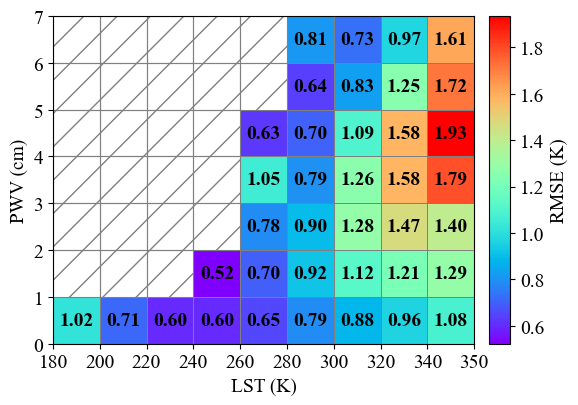

In [86]:
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(figsize=(6,6))
sc = ax.pcolormesh(rmses, cmap='rainbow', edgecolors='gray', linewidths=0.7)

for i in range(rmses.shape[0]):
    for j in range(rmses.shape[1]):
        if np.isnan(rmses[i,j]):
            rect = plt.Rectangle((j, i), 1, 1, hatch='/', fill=False, edgecolor='gray', linewidth=0.8)
            ax.add_patch(rect)
        else:
            ax.text(j+0.5, i+0.5, f'{rmses[i,j]:.2f}', ha='center', va='center', color='black', fontweight='bold')

ax.set_xlabel('LST (K)')
ax.set_ylabel('PWV (cm)')
tick_labels = [str(edge) for edge in lst_edges]
tick_labels.append(350)
ax.set_xticks(ticks=np.arange(10), labels=tick_labels)
ax.set_aspect('equal')

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15) # size: control width, pad: control distance
cbar = plt.colorbar(sc, cax=cax)
cbar.set_label('RMSE (K)')

fig.tight_layout()

# fig.savefig('figs/rmse_bins_w_tpw.tif', dpi=300, bbox_inches='tight')

# compare inference speed

In [ ]:
import numpy as np
from catboost import CatBoostRegressor, FeaturesData, Pool
from lib.models import *
import time
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_cat = CatBoostRegressor()
model_cat.load_model("model/catboost/model_w_tpw_wo_noise.cbm")

params_model = {'d_in': 5, 'd_out': 3, 'd_block':128, 'd_hidden':64, 'n_block_l':3, 'n_block_h':2, 'act':'sigmoid', 'skip': True}
model_dl = Res_MLP(**params_model).to(device)
weight_path = 'model/res_mlp/model_w_tpw.pt'
model_dl.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

In [ ]:
num_x_all = [int(1e6), int(2e6), int(5e6), int(1e7), int(2e7), int(5e7)]
times_cat = np.zeros((len(num_x_all), 5))
times_dl = np.zeros((len(num_x_all), 5))
sample_in_batch = 1000000

for num_x in tqdm(num_x_all):
    x = np.random.rand(num_x,5)
    feature_data = FeaturesData(num_feature_data=x.astype(np.float32))
    data_pool = Pool(data=feature_data)
    x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
    num_batch = num_x // sample_in_batch

    model_dl.eval()
    with torch.no_grad():
        for i in range(5):
            time_start = time.time()
            _ = model_cat.predict(data_pool)
            time_end = time.time()
            times_cat[num_x_all.index(num_x), i] = time_end-time_start

            time_start = time.time()
            for j in range(num_batch):
                _ = model_dl(x_tensor[j*sample_in_batch:(j+1)*sample_in_batch])
            time_end = time.time()
            times_dl[num_x_all.index(num_x), i] = time_end-time_start

# speed = {'cat': times_cat, 'dl': times_dl}
# pickle.dump(speed, open('result/speed.pkl','wb'))

100%|██████████| 6/6 [05:45<00:00, 57.65s/it]


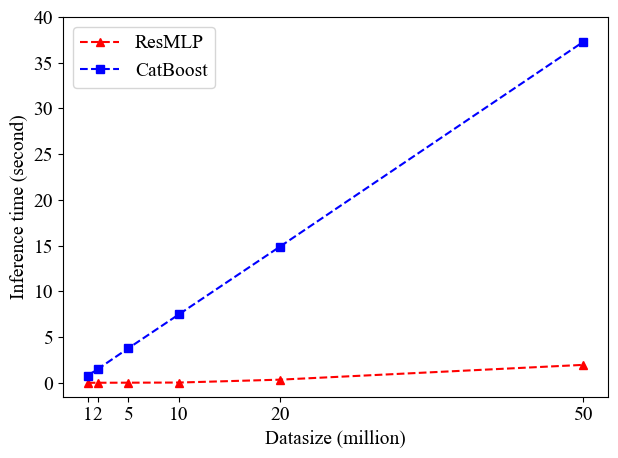

In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

speed = pickle.load(open('result/speed.pkl','rb'))
times_cat, times_dl = speed['cat'], speed['dl']
times_cat_med = np.median(np.sort(times_cat, axis=1), axis=1)
times_dl_med = np.median(np.sort(times_dl, axis=1), axis=1)

xx = [1, 2, 5, 10, 20, 50]
fig, ax = plt.subplots()
ax.plot(xx, times_dl_med, marker='^', linestyle='--', color='red', label='ResMLP')
ax.plot(xx, times_cat_med, marker='s', linestyle='--', color='blue', label='CatBoost')
ax.set_xticks(xx)
ax.set_ylim([-1.5, 40])
# ax.set_xticklabels()

ax.set_xlabel('Datasize (million)')
ax.set_ylabel('Inference time (second)')
ax.legend()

fig.tight_layout()
fig.savefig('figs/speed.tif', dpi=300, bbox_inches='tight')